# Human Classification Task 2

In [6]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from Preprocessing import preprocessRGB,facefeaturesdlib
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D,Dropout
from keras.layers import MaxPooling2D 
from keras.models import Model
from keras.preprocessing import image
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import h5py
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping


__________________________________________________

___________________________


_______________________________________

## Convolutional Neural Network

In [7]:
def convModel(input_shape):
    
    
    
   
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (5, 5), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    #X = Dropout(.3)(X)
    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool_0')(X)
    
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(50, (2, 2), strides = (1, 1), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)
    X = Dropout(.3)(X)
    X = MaxPooling2D((3, 3), name='max_pool_1')(X)
    
    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(256, activation='relu', name='fc0')(X)
    X = Dropout(.3)(X)
    X = Dense(128, activation='relu', name='fc1')(X)
    X = Dropout(.3)(X)
    X = Dense(1, activation='sigmoid', name='fc2')(X)
    

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='cutomModel')

    return model

import images as rgb (64,64,3)

In [8]:
x_testfiles,cx_train,cy_train,cx_test,cy_test=preprocessRGB('human',.2,(64,64))

Creating model , compiling it , creating callbacks for early stopping and plotting

In [9]:
humanmodel=convModel(cx_train.shape[1:])
#opt=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
humanmodel.compile(optimizer='adam',loss='binary_crossentropy',metrics = ["accuracy"])
monitor= EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=5,verbose=1,mode='auto')
checkpointer =ModelCheckpoint(filepath='humanCNN1.hdf5',verbose=1,save_best_only=True)

Training CNN 50 mins with validation split and batch sizr 16 until improvement stops

In [10]:
historyCNN = humanmodel.fit(x=cx_train, y=cy_train, validation_split=0.2, epochs=100, batch_size=16,callbacks=[monitor,checkpointer], verbose=1)

Train on 2828 samples, validate on 708 samples
Epoch 1/100
2828/2828 [==============================] - 142s 50ms/step - loss: 0.1436 - acc: 0.9735 - val_loss: 3.0260 - val_acc: 0.7246

Epoch 00001: val_loss improved from inf to 3.02596, saving model to humanCNN1.hdf5
Epoch 2/100
2828/2828 [==============================] - 136s 48ms/step - loss: 0.0158 - acc: 0.9979 - val_loss: 0.0177 - val_acc: 0.9958

Epoch 00002: val_loss improved from 3.02596 to 0.01768, saving model to humanCNN1.hdf5
Epoch 3/100
2828/2828 [==============================] - 124s 44ms/step - loss: 0.0886 - acc: 0.9894 - val_loss: 1.1372 - val_acc: 0.8969

Epoch 00003: val_loss did not improve
Epoch 4/100
2828/2828 [==============================] - 123s 44ms/step - loss: 0.0287 - acc: 0.9982 - val_loss: 0.0043 - val_acc: 0.9986

Epoch 00004: val_loss improved from 0.01768 to 0.00432, saving model to humanCNN1.hdf5
Epoch 5/100
2828/2828 [==============================] - 148s 52ms/step - loss: 0.0636 - acc: 0.9940 -

In [12]:
humanmodel.load_weights('humanCNN1.hdf5')
humanmodel.save('humanCNN.h5')

In [13]:
from keras.models import load_model
humanmodel= load_model('humanCNN.h5')
preds =humanmodel.evaluate(x =cx_test, y =cy_test)

print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

884/884 [==============================] - 12s 13ms/step

Loss = 2.539095663215403e-07
Test Accuracy = 1.0


In [14]:
import pandas as pd
yhat=humanmodel.predict(cx_test)
df =pd.DataFrame(x_testfiles)
df['pred']=(np.round(yhat,0))
pred=np.array(df)
np.savetxt('Task4.csv', pred, delimiter=',',header=str(preds[1]))

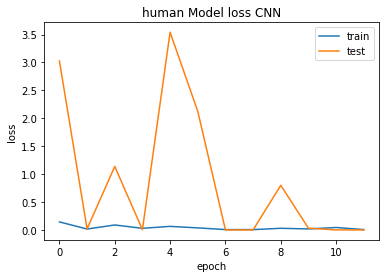

In [16]:
plt.plot(historyCNN.history['loss'])
plt.plot(historyCNN.history['val_loss'])
plt.title('human Model loss CNN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

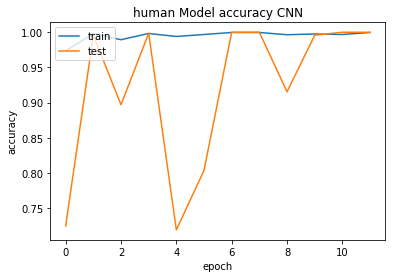

In [17]:
plt.plot(historyCNN.history['acc'])
plt.plot(historyCNN.history['val_acc'])
plt.title('human Model accuracy CNN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
from sklearn.metrics import confusion_matrix
conf= confusion_matrix(cy_test,np.round(yhat,0))

In [19]:
conf

array([[476,   0],
       [  0, 408]], dtype=int64)

In [21]:
i=0
NewTest=np.zeros((100,64,64,3))
for x in range(1,101):
    temp= image.load_img('testing_dataset/'+str(x)+'.png',target_size=(64,64))
    NewTest[i,:,:,:]=image.img_to_array(temp)
    i=i+1
NewTest=NewTest/255

yhat=humanmodel.predict(NewTest)
yhat=np.round(yhat,0)
df1 =pd.DataFrame(yhat)
df = pd.DataFrame(list(range(1,101)))
df['pred']=list(df1.max(axis=1))
pred=np.array(df)
np.savetxt('Testing_dataset_Task4.csv', pred, delimiter=',',header=str(preds[1]))